In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import random
import cv2
import os
import tensorflow as tf
from tqdm import tqdm

In [3]:
good_frames = '../input/blur-dataset/sharp'
bad_frames = '../input/blur-dataset/defocused_blurred'

In [4]:
clean_frames = []
for file in tqdm(sorted(os.listdir(good_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(good_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        clean_frames.append(image)

clean_frames = np.array(clean_frames)
blurry_frames = []
for file in tqdm(sorted(os.listdir(bad_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        blurry_frames.append(image)

blurry_frames = np.array(blurry_frames)

100%|██████████| 350/350 [00:16<00:00, 21.49it/s]


In [5]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import backend as K

seed = 21
random.seed = seed
np.random.seed = seed

In [6]:
x = clean_frames;
y = blurry_frames;
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
print(x_train[0].shape)
print(y_train[0].shape)

(128, 128, 3)
(128, 128, 3)


208


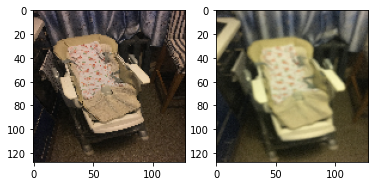

In [8]:
r = random.randint(0, len(clean_frames)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frames[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blurry_frames[r])

In [9]:
# Network Parameters
input_shape = (128, 128, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [10]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

In [11]:
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

2022-07-14 07:14:20.749011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 07:14:20.859793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 07:14:20.860695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 07:14:20.861788: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               16777472  
Total params: 17,148,288
Trainable params: 17,148,288
Non-trainable params: 0
_______________________________________________

In [13]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [14]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 65536)             16842752  
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 64)      73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 128, 128, 3)       1731

In [15]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Functional)         (None, 256)               17148288  
_________________________________________________________________
decoder (Functional)         (None, 128, 128, 3)       17803395  
Total params: 34,951,683
Trainable params: 34,951,683
Non-trainable params: 0
_________________________________________________________________


In [16]:
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

In [17]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [19]:
callbacks = [lr_reducer]
history = autoencoder.fit(blurry_frames,
                      clean_frames,
                      validation_data=(blurry_frames, clean_frames),
                      epochs=100,
                      batch_size=batch_size,
                      callbacks=callbacks)

Epoch 1/100
9/9 [==============================] - 1s 113ms/step - loss: 0.0099 - acc: 0.7055 - val_loss: 0.0095 - val_acc: 0.7096
Epoch 2/100
9/9 [==============================] - 1s 88ms/step - loss: 0.0096 - acc: 0.7122 - val_loss: 0.0092 - val_acc: 0.7248
Epoch 3/100
9/9 [==============================] - 1s 85ms/step - loss: 0.0093 - acc: 0.7275 - val_loss: 0.0093 - val_acc: 0.7262
Epoch 4/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0093 - acc: 0.7136 - val_loss: 0.0089 - val_acc: 0.7140
Epoch 5/100
9/9 [==============================] - 1s 85ms/step - loss: 0.0091 - acc: 0.7214 - val_loss: 0.0086 - val_acc: 0.7158
Epoch 6/100
9/9 [==============================] - 1s 85ms/step - loss: 0.0087 - acc: 0.7270 - val_loss: 0.0087 - val_acc: 0.7419
Epoch 7/100
9/9 [==============================] - 1s 86ms/step - loss: 0.0087 - acc: 0.7315 - val_loss: 0.0083 - val_acc: 0.7032
Epoch 8/100
9/9 [==============================] - 1s 88ms/step - loss: 0.0084 - acc: 0.7


       Input                        Ground Truth                  Predicted Value


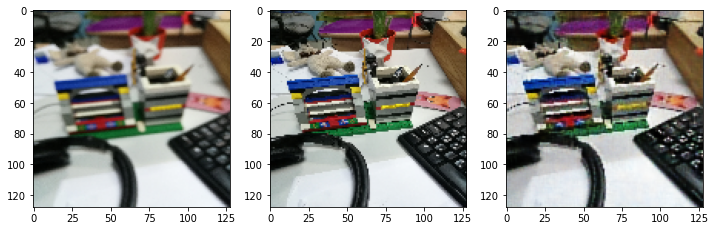

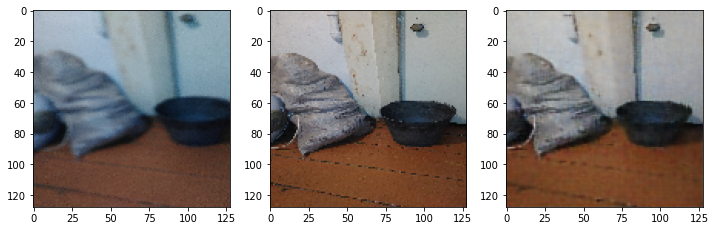

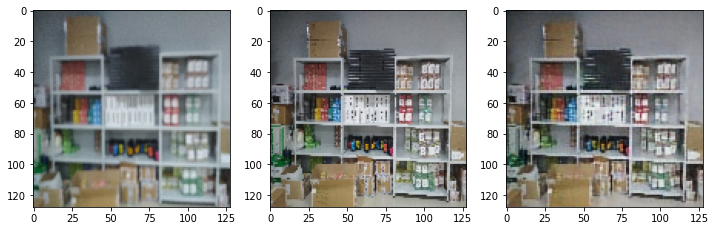

In [20]:
print("\n       Input                        Ground Truth                  Predicted Value")
for i in range(3):
    
    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r],clean_frames[r]
    x_inp=x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)

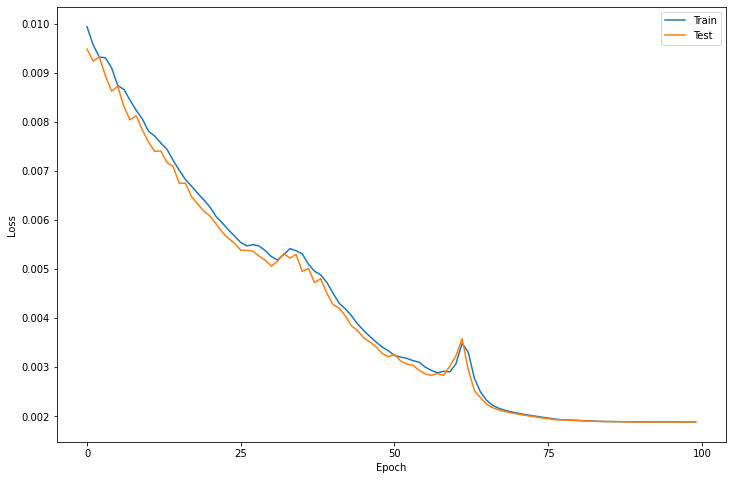

In [21]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 101, 25))
plt.show()

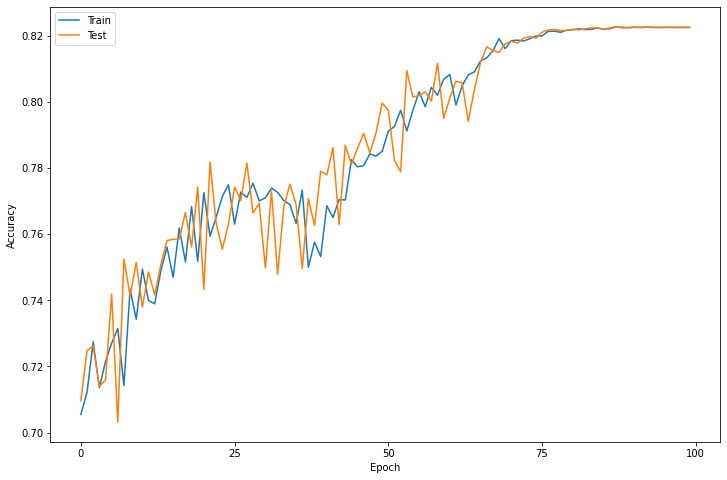

In [22]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 101, 25))
plt.show()

Kindly upvote!